<a href="https://colab.research.google.com/github/CarolBw/Projeto-MVP-Engenharia-de-Dados-PUC-RJ/blob/main/Projeto_MVP_Engenharia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto MVP Análise Temporal da moeda Dirham (UAE) e suas correlações com o clima.

Projeto MVP: Análise Temporal da Moeda Dirham (UAE) e Suas Correlações com o Clima
Este projeto visa a criação de um pipeline de dados automatizado para analisar a variação da moeda Dirham (UAE) ao longo de 10 anos, compreendendo seus padrões anuais e a existência de relação de sua variação com a temperatura na cidade de Dubai (UAE). Utilizando um esquema estrela em um Data Warehouse. Extraímos, limpamos, transformamos e carregamos os dados históricos da moeda e da temperatura.

Os resultados serão apresentados através de dashboards, facilitando a visualização e interpretação dos padrões sazonais e anuais, bem como a correlação entre o valor do Dirham e a temperatura.

Perguntas norteadoras vide documento de análise anexado.


## Ferramentas e Serviços Utilizados:

  * Google Cloud Storage (GCS): Armazenamento de dados brutos.
  * Cloud Composer: Orquestração de pipelines de dados com Apache Airflow.
  * Google BigQuery: Data Warehouse para armazenamento e análise de dados.
  * PostgreSQL: Banco de dados relacional para armazenar dados no data warehouse.
  * Apache Spark: Framework para processamento de dados distribuído.
  * Databricks: Ambiente de desenvolvimento e execução de Spark.
  * Bibliotecas Básicas (pandas, numpy, etc.): Manipulação de dados em Python.
  * GitHub: Controle de versão para colaboração e gerenciamento de código.


## Fluxo do Pipeline:

* Fonte de Dados: APIs Yahoo Finance (moedas) e Meteostat (temperatura).

1. Extração:

  * Cloud Composer DAG: Inicia a extração periódica de dados.

  * Google Cloud Storage (GCS): Armazenamento de Dados Brutos (Armazena arquivos CSV/JSON com dados extraídos).

2. Processamento e Transformação:

  * Databricks com Spark: Lê os dados brutos do GCS, realiza transformações e salva dados transformados no PostgreSQL e BigQuery.

3. Carregamento de Dados Preparados:

  * PostgreSQL: Armazena dados transformados para análises no data warehouse.

  * BigQuery: Importa dados transformados do GCS, cria um esquema estrela para análises OLAP (tabelas de fato e dimensões).

4. Análise e Visualização:

  * BigQuery: Realiza consultas analíticas para análise de correlação entre Dirham, dólar, real e temperaturas de Dubai.

  * Cloud Composer: Gerencia o fluxo de trabalho completo, agendando e orquestrando os processos no Apache Airflow.

## Configurações iniciais:

1. Criar Conta no Google Cloud:

  * Criar uma conta no Google Cloud Platform (GCP).
  * Criar um projeto no Google Cloud Console.
  * Habilitar as APIs do Cloud Storage, BigQuery, Cloud Composer e Cloud SQL(Postgre) no Console do GCP.

2. Configurar Conta de Serviço:

  * Criar uma conta de serviço no Console do GCP.
  * Atribuir permissões especificas.
  * Gerar e baixar a chave JSON associada à conta de serviço para autenticação.

3. Configurar Bucket no Google Cloud Storage:

  * Criar um bucket no Google Cloud Storage para armazenamento de dados brutos.
  * Configurar permissões de acesso e segurança.

4. Configurar Google BigQuery:

  * Configurar e inicializar o BigQuery como o data warehouse para armazenamento de dados transformados e análise.

5. Configurar Ambiente do Cloud Composer:

  * Criar um ambiente do Cloud Composer no Console do GCP.
  * Definir a região, o nome do ambiente e as configurações necessárias.
  * Associar o ambiente ao projeto do Google Cloud.


## Configurando o ambiente:



In [1]:
# Instalando as bibliotecas
%pip install pandas # manipulação de dados estruturados
%pip install requests # Requisições HTTP
%pip install yfinance # Acesso a dados financeiros do Yahoo Finance
%pip install meteostat # Acesso a dados do clima
%pip install psycopg2-binary # Conexão com bancos de dados PostgreSQL
%pip install sqlalchemy # interação com bancos de dados SQL
%pip install pyspark # Processamento de dados distribuído com Apache Spark
%pip install findspark # Configuração do ambiente para utilizar o Spark com Python
%pip install pygithub # interação com a API do GitHub
%pip install google-cloud-storage # Acesso ao Google Cloud Storage
%pip install google-cloud-bigquery # Acesso ao Google BigQuery
%pip install apache-airflow # Orquestração de pipelines de dados com Apache Airflow
!apt-get install postgresql postgresql-contrib



  Using cached apache_airflow-2.9.2-py3-none-any.whl (13.3 MB)
  Using cached alembic-1.13.2-py3-none-any.whl (232 kB)
  Using cached argcomplete-3.4.0-py3-none-any.whl (42 kB)
  Using cached asgiref-3.8.1-py3-none-any.whl (23 kB)
  Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)
  Using cached connexion-2.14.2-py2.py3-none-any.whl (95 kB)
  Using cached croniter-2.0.5-py2.py3-none-any.whl (20 kB)
  Using cached Flask_Caching-2.3.0-py3-none-any.whl (28 kB)
  Using cached flask_session-0.5.0-py3-none-any.whl (7.2 kB)
  Using cached flask_wtf-1.2.1-py3-none-any.whl (12 kB)
  Using cached httpx-0.27.0-py3-none-any.whl (75 kB)
  Using cached marshmallow_oneofschema-3.1.1-py3-none-any.whl (5.7 kB)
  Using cached methodtools-0.4.7-py3-none-any.whl
  Using cached opentelemetry_api-1.25.0-py3-none-any.whl (59 kB)
  Using cached opentelemetry_exporter_otlp-1.25.0-py3-none-any.whl (7.0 kB)
  Using cached pendulum-3.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (384 kB)
  Us

In [2]:
# Importações
import pandas as pd  # Importação e manipulação de dados
import numpy as np  # Computação numérica e manipulação de arrays
import requests  # Requisições HTTP para interação com APIs web
import yfinance as yf  # Acesso a dados financeiros do Yahoo Finance
from datetime import datetime  # Manipulação de datas e horários em Python
import matplotlib.pyplot as plt  # Plotagem de gráficos e visualizações
import seaborn as sns  # Visualização de dados estatísticos e gráficos
import os  # Funcionalidades do sistema operacional
import psycopg2  # Conexão e interação com bancos de dados PostgreSQL
import sqlalchemy  # Ferramenta SQL para bancos de dados
from github import Github  # Acesso à API do GitHub
from google.cloud import storage  # Acesso ao Google Cloud Storage
from google.cloud import bigquery  # Acesso ao Google BigQuery
from pyspark.sql import SparkSession  # Criação de sessões Spark para processamento de dados distribuído
import findspark  # Configuração do ambiente para utilizar o Spark com Python


In [3]:
# Instalação e configuração do Apache Spark

# Instalando pacotes necessários
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.olnevhost.net/pub/apache/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

# Download do driver JDBC para PostgreSQL
!wget https://jdbc.postgresql.org/download/postgresql-42.2.18.jar -P /content/

# Configurando o caminho para o arquivo JAR do PostgreSQL
jdbc_driver_path = "/content/postgresql-42.2.18.jar"

# Inicializando o Spark
findspark.init()

# Configurando o SparkSession com o driver JDBC
spark = SparkSession.builder \
    .appName("PostgreSQL Spark Integration") \
    .config("spark.driver.extraClassPath", jdbc_driver_path) \
    .config("spark.jars", jdbc_driver_path) \
    .getOrCreate()


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,263 kB]
Get:14 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,410 kB]
Fetched 3,930 kB in 3s (1,344 kB/s)
Rea

In [4]:
# Configurando as variaveis de ambiente para conexão com Postgre e Google Cloud

# Configurando variaveis de ambiente para o PostgreSQL
os.environ['POSTGRES_USER'] = 'admin_db'
os.environ['POSTGRES_PASSWORD'] = 'AWSCarol20'
os.environ['POSTGRES_HOST'] = '34.133.59.52'
os.environ['POSTGRES_PORT'] = '5432'
os.environ['POSTGRES_DB'] = 'dubai-dbb'

# Configurações da chave de serviço para acesso ao Google Cloud
json_file_path = "/content/Chave-JSON-Composer2.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = json_file_path
os.environ['bucket_name'] = "cloud-storage-bucket-001"

# Configurando variáveis de ambiente do Spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"



In [5]:
from google.cloud import storage
from google.cloud import bigquery
from google.colab import auth

auth.authenticate_user()

# Criar uma Instância do PostgreSQL
# Google Cloud > Ativar a API do Cloud SQL ("Cloud SQL Admin API") > Criar instancia > Anotar dados de conexão > Conectar usando Cloud shell.

# Conectar ao Google Cloud Storage
gcs_client = storage.Client()

# Conectar ao BigQuery
bq_client = bigquery.Client()

# Extração de dados




In [6]:
import yfinance as yf
from datetime import datetime

# Definindo a função de extração do Yahoo Finance
def extrair_dados_yahoo_finance(ticker, start_date, end_date):
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        if df.empty:
            raise ValueError(f"Nenhum dado encontrado para o ticker {ticker}")
        return df
    except Exception as e:
        print(f"Erro ao extrair dados para o ticker {ticker}: {e}")
        return None

# Definir os tickers Dolar/Dirham e Dolar/Real
usd_aed_ticker = 'USDAED=X'
usd_brl_ticker = 'USDBRL=X'

# Definir intervalo de datas
start_date = datetime(2013, 1, 1)
end_date = datetime(2024, 1, 1)

# Extrair os dados históricos
df_usd_aed = extrair_dados_yahoo_finance(usd_aed_ticker, start_date, end_date)
df_usd_brl = extrair_dados_yahoo_finance(usd_brl_ticker, start_date, end_date)

# Visualizar informações básicas dos DataFrames
if df_usd_aed is not None:
    print("Informações básicas para USD/AED:")
    print(df_usd_aed.info())

if df_usd_brl is not None:
    print("\nInformações básicas para USD/BRL:")
    print(df_usd_brl.info())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Informações básicas para USD/AED:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2867 entries, 2013-01-01 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2867 non-null   float64
 1   High       2867 non-null   float64
 2   Low        2867 non-null   float64
 3   Close      2867 non-null   float64
 4   Adj Close  2867 non-null   float64
 5   Volume     2867 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 156.8 KB
None

Informações básicas para USD/BRL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2864 entries, 2013-01-01 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2864 non-null   float64
 1   High       2864 non-null   float64
 2   Low        2864 non-null   float64
 3   Close      2864 non-null   float64
 4   Adj Close  2864 non-null   float64
 5   Volume     2864 non-n

In [7]:
import pandas as pd

# Definindo a função de limpeza da extração do Yahoo Finance
def limpeza_dados_yahoo_finance(df, prefixo):
    colunas_renomeadas = {
        'Close': f'{prefixo}_Close',
        'High': f'{prefixo}_High',
        'Low': f'{prefixo}_Low',
        'Open': f'{prefixo}_Open'
    }
    df = df[['Close', 'High', 'Low', 'Open']].rename(columns=colunas_renomeadas)

    # Criar uma coluna 'Date' a partir do índice que contém as datas
    df['Date'] = df.index

    # Garantir que a coluna 'Date' esteja no formato Datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Resetar os índices
    df.reset_index(drop=True, inplace=True)

    return df

# Chamando a função para aplicar as transformações iniciais necessárias
df_usd_aed = limpeza_dados_yahoo_finance(df_usd_aed, 'USD_AED')
df_usd_brl = limpeza_dados_yahoo_finance(df_usd_brl, 'USD_BRL')

# Imprimir para verificar como ficou após a limpeza e transformação
print("Dados do par USD/AED após limpeza e transformação:")
print(df_usd_aed)

print("\nDados do par USD/BRL após limpeza e transformação:")
print(df_usd_brl)

Dados do par USD/AED após limpeza e transformação:
      USD_AED_Close  USD_AED_High  USD_AED_Low  USD_AED_Open       Date
0            3.6721        3.6721       3.6721        3.6721 2013-01-01
1            3.6720        3.6729       3.6718        3.6720 2013-01-02
2            3.6720        3.6729       3.6720        3.6720 2013-01-03
3            3.6720        3.6729       3.6720        3.6720 2013-01-04
4            3.6721        3.6729       3.6720        3.6721 2013-01-07
...             ...           ...          ...           ...        ...
2862         3.6716        3.6719       3.6716        3.6716 2023-12-25
2863         3.6716        3.6725       3.6716        3.6716 2023-12-26
2864         3.6725        3.6727       3.6716        3.6725 2023-12-27
2865         3.6718        3.6726       3.6718        3.6718 2023-12-28
2866         3.6726        3.6726       3.6718        3.6726 2023-12-29

[2867 rows x 5 columns]

Dados do par USD/BRL após limpeza e transformação:
      US

In [8]:
import pandas as pd

# Definindo a função para mesclar dois DataFrames pela coluna 'Date'
def mesclar_dataframes_por_data(df1, df2):
    # Garantindo que a coluna 'Date' esteja no formado datetime
    if 'Date' in df1.columns:
        df1['Date'] = pd.to_datetime(df1['Date'])
    if 'Date' in df2.columns:
        df2['Date'] = pd.to_datetime(df2['Date'])

    # Mesclando os DataFrames usando a coluna 'Date'
    df_merged = pd.merge(df1, df2, on='Date', how='inner')

    return df_merged

# Mesclando os DataFrames df_usd_aed e df_usd_brl pela coluna 'Date'
df_merged = mesclar_dataframes_por_data(df_usd_aed, df_usd_brl)
df1 = df_merged

# Imprimir para verificar como ficou após a mesclagem
print("Dados mesclados dos pares USD/AED e USD/BRL:")
print(df1)


Dados mesclados dos pares USD/AED e USD/BRL:
      USD_AED_Close  USD_AED_High  USD_AED_Low  USD_AED_Open       Date  \
0            3.6721        3.6721       3.6721        3.6721 2013-01-01   
1            3.6720        3.6729       3.6718        3.6720 2013-01-02   
2            3.6720        3.6729       3.6720        3.6720 2013-01-03   
3            3.6720        3.6729       3.6720        3.6720 2013-01-04   
4            3.6721        3.6729       3.6720        3.6721 2013-01-07   
...             ...           ...          ...           ...        ...   
2858         3.6716        3.6719       3.6716        3.6716 2023-12-25   
2859         3.6716        3.6725       3.6716        3.6716 2023-12-26   
2860         3.6725        3.6727       3.6716        3.6725 2023-12-27   
2861         3.6718        3.6726       3.6718        3.6718 2023-12-28   
2862         3.6726        3.6726       3.6718        3.6726 2023-12-29   

      USD_BRL_Close  USD_BRL_High  USD_BRL_Low  USD_BR

In [9]:
from meteostat import Point, Daily
from datetime import datetime

# Definindo a função que realiza a extração de dados de temperatuda das coordenadas da cidade de Dubai (UAE)
def extrair_dados_meteostat(latitude, longitude, start_date, end_date):
    location = Point(latitude, longitude)

    # Obter dados diários de temperatura
    df = Daily(location, start_date, end_date)
    df = df.fetch()

    return df

def limpeza_e_transformacao(df):
    try:
        # Criando uma coluna 'Date' a partir do índice que contém as datas
        df['Date'] = df.index

        # Redefinindo o índice
        df.reset_index(inplace=True)

        # Selecionando e mantendo apenas as colunas de interesse
        df = df[['Date', 'tmax', 'tmin', 'tavg']]

        # Renomeando as colunas para facilitar a manipulação
        df.rename(columns={'tmax': 'Temp_Max_Dubai', 'tmin': 'Temp_Min_Dubai', 'tavg': 'Temp_Media_Dubai'}, inplace=True)

        return df

    except Exception as e:
        print(f'Erro durante a limpeza e transformação dos dados: {str(e)}')
        return None

# Uso:

# Parâmetros para a extração de dados
latitude = 25.276987
longitude = 55.296249
start_date = datetime(2013, 1, 1)
end_date = datetime(2024, 1, 1)

# Extrair dados de temperatura
df_temperatura_dubai = extrair_dados_meteostat(latitude, longitude, start_date, end_date)

# Chamando a função para limpeza e transformação
df_limpo_transformado = limpeza_e_transformacao(df_temperatura_dubai)
df2 = df_limpo_transformado

# Exibindo o resultado para verificar como ficou
print("DataFrame após limpeza e transformação:")
print(df2)



DataFrame após limpeza e transformação:
           Date  Temp_Max_Dubai  Temp_Min_Dubai  Temp_Media_Dubai
0    2013-01-01            24.1            15.7              20.4
1    2013-01-02            25.5            15.2              20.9
2    2013-01-03            25.1            15.9              21.0
3    2013-01-04            25.0            16.2              21.5
4    2013-01-05            24.4            17.5              20.8
...         ...             ...             ...               ...
4013 2023-12-28            27.4            18.0              23.1
4014 2023-12-29            28.8            19.3              23.9
4015 2023-12-30            29.6            20.4              24.3
4016 2023-12-31            27.0            20.4              24.4
4017 2024-01-01            27.7            20.8              24.6

[4018 rows x 4 columns]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
from google.cloud import storage
import pandas as pd

# Função para mesclar dois DataFrames pela coluna 'Date' e visualizar como ficou
def mesclar_e_visualizar(df1, df2):
    try:
        # Mesclar os DataFrames pela coluna 'Date'
        df_merged = pd.merge(df1, df2, on='Date', how='inner')

        # Visualizar como ficou o DataFrame mesclado
        print("DataFrame mesclado:")
        print(df_merged)

        return df_merged

    except Exception as e:
        print(f'Erro ao mesclar os DataFrames: {str(e)}')
        return None


# Chamando a função para mesclar e visualizar
df_merged = mesclar_e_visualizar(df1, df2)


DataFrame mesclado:
      USD_AED_Close  USD_AED_High  USD_AED_Low  USD_AED_Open       Date  \
0            3.6721        3.6721       3.6721        3.6721 2013-01-01   
1            3.6720        3.6729       3.6718        3.6720 2013-01-02   
2            3.6720        3.6729       3.6720        3.6720 2013-01-03   
3            3.6720        3.6729       3.6720        3.6720 2013-01-04   
4            3.6721        3.6729       3.6720        3.6721 2013-01-07   
...             ...           ...          ...           ...        ...   
2858         3.6716        3.6719       3.6716        3.6716 2023-12-25   
2859         3.6716        3.6725       3.6716        3.6716 2023-12-26   
2860         3.6725        3.6727       3.6716        3.6725 2023-12-27   
2861         3.6718        3.6726       3.6718        3.6718 2023-12-28   
2862         3.6726        3.6726       3.6718        3.6726 2023-12-29   

      USD_BRL_Close  USD_BRL_High  USD_BRL_Low  USD_BRL_Open  Temp_Max_Dubai  \

In [11]:
# Função para salvar o DataFrame no Google Cloud Storage
def salvar_no_gcs(dataframe, bucket_name, file_name):
    try:
        # Conectar ao Google Cloud Storage
        storage_client = storage.Client()

        # Acessar o bucket
        bucket = storage_client.bucket(bucket_name)

        # Transformar o DataFrame em um arquivo CSV temporário
        temp_csv_file = '/tmp/temp_data.csv'
        dataframe.to_csv(temp_csv_file, index=False)

        # Carregar o arquivo CSV para o bucket do Google Cloud Storage
        blob = bucket.blob(file_name)
        blob.upload_from_filename(temp_csv_file)

        print(f'Dados salvos no bucket {bucket_name}, arquivo {file_name}.')

    except Exception as e:
        print(f'Erro ao salvar dados no bucket {bucket_name}, arquivo {file_name}: {str(e)}')

# Chamando a função para salvar no Google Cloud Storage
bucket_name = 'cloud-storage-bucket-001'
file_name = 'dados_brutos.csv'

if df_merged is not None:
    salvar_no_gcs(df_merged, bucket_name, file_name)

Dados salvos no bucket cloud-storage-bucket-001, arquivo dados_brutos.csv.


# Análise exploratória de dados

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from google.cloud import storage
import io

In [13]:

# Função para baixar os dados do Google Cloud Storage e carregá-los em um DataFrame
def carregar_dados_do_gcs(bucket_name, file_name):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(file_name)
    content = blob.download_as_string()
    df = pd.read_csv(io.BytesIO(content))
    return df

# Configurações do Google Cloud Storage
bucket_name = 'cloud-storage-bucket-001'
file_name = 'dados_brutos.csv'

# Carregar os dados brutos do Google Cloud Storage
df = carregar_dados_do_gcs(bucket_name, file_name)

# Verificar se os dados foram carregados corretamente
print(df.head())


   USD_AED_Close  USD_AED_High  USD_AED_Low  USD_AED_Open        Date  \
0         3.6721        3.6721       3.6721        3.6721  2013-01-01   
1         3.6720        3.6729       3.6718        3.6720  2013-01-02   
2         3.6720        3.6729       3.6720        3.6720  2013-01-03   
3         3.6720        3.6729       3.6720        3.6720  2013-01-04   
4         3.6721        3.6729       3.6720        3.6721  2013-01-07   

   USD_BRL_Close  USD_BRL_High  USD_BRL_Low  USD_BRL_Open  Temp_Max_Dubai  \
0         2.0507        2.0540       2.0435        2.0507            24.1   
1         2.0456        2.0503       2.0350        2.0455            25.5   
2         2.0456        2.0485       2.0282        2.0456            25.1   
3         2.0487        2.0488       2.0273        2.0488            25.0   
4         2.0324        2.0368       2.0147        2.0329            29.3   

   Temp_Min_Dubai  Temp_Media_Dubai  
0            15.7              20.4  
1            15.2     

In [14]:

# Função para verificar informações básicas do conjunto de dados
def verificar_informacoes(df):
    print(df.info())

verificar_informacoes(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863 entries, 0 to 2862
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   USD_AED_Close     2863 non-null   float64
 1   USD_AED_High      2863 non-null   float64
 2   USD_AED_Low       2863 non-null   float64
 3   USD_AED_Open      2863 non-null   float64
 4   Date              2863 non-null   object 
 5   USD_BRL_Close     2863 non-null   float64
 6   USD_BRL_High      2863 non-null   float64
 7   USD_BRL_Low       2863 non-null   float64
 8   USD_BRL_Open      2863 non-null   float64
 9   Temp_Max_Dubai    2863 non-null   float64
 10  Temp_Min_Dubai    2863 non-null   float64
 11  Temp_Media_Dubai  2863 non-null   float64
dtypes: float64(11), object(1)
memory usage: 268.5+ KB
None


In [15]:

# Função para verificar consistência do conjunto de dados
def verificar_consistencia(df):
    # Verificar valores ausentes
    valores_ausentes = df.isnull().sum()
    print("Valores ausentes em cada coluna:")
    print(valores_ausentes)

    # Verificar valores nulos
    valores_nulos = df.isna().sum()
    print("\nValores nulos em cada coluna:")
    print(valores_nulos)

    # Verificar valores não numéricos
    valores_nao_numericos = df.select_dtypes(exclude=[np.number])
    print("\nColunas com valores não numéricos:")
    print(valores_nao_numericos.columns)

    # Verificar valores duplicados
    valores_duplicados = df.duplicated().sum()
    print(f"\nNúmero de linhas duplicadas: {valores_duplicados}")

    # Garantir que todas as colunas tenham a mesma quantidade de linhas
    linhas_por_coluna = df.count()
    print("\nQuantidade de linhas por coluna:")
    print(linhas_por_coluna)

    # Verificar se temos outliers
    outliers = df.describe().transpose()
    print("\nVerificação de outliers (estatísticas descritivas):")
    print(outliers)

    # Variância
    var_min = df['Temp_Min_Dubai'].var()
    var_media = df['Temp_Media_Dubai'].var()
    var_max = df['Temp_Max_Dubai'].var()
    print("Variância Temp_Min:", var_min)
    print("Variância Temp_Media:", var_media)
    print("Variância Temp_Max:", var_max)

verificar_consistencia(df)

Valores ausentes em cada coluna:
USD_AED_Close       0
USD_AED_High        0
USD_AED_Low         0
USD_AED_Open        0
Date                0
USD_BRL_Close       0
USD_BRL_High        0
USD_BRL_Low         0
USD_BRL_Open        0
Temp_Max_Dubai      0
Temp_Min_Dubai      0
Temp_Media_Dubai    0
dtype: int64

Valores nulos em cada coluna:
USD_AED_Close       0
USD_AED_High        0
USD_AED_Low         0
USD_AED_Open        0
Date                0
USD_BRL_Close       0
USD_BRL_High        0
USD_BRL_Low         0
USD_BRL_Open        0
Temp_Max_Dubai      0
Temp_Min_Dubai      0
Temp_Media_Dubai    0
dtype: int64

Colunas com valores não numéricos:
Index(['Date'], dtype='object')

Número de linhas duplicadas: 0

Quantidade de linhas por coluna:
USD_AED_Close       2863
USD_AED_High        2863
USD_AED_Low         2863
USD_AED_Open        2863
Date                2863
USD_BRL_Close       2863
USD_BRL_High        2863
USD_BRL_Low         2863
USD_BRL_Open        2863
Temp_Max_Dubai      286

In [18]:
# Função para analisar estatísticas básicas agrupadas por dia, mês e ano
def analisar_estatisticas(df):
    # Garantir que a coluna 'Date' esteja em Datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Extrair o ano, mês e dia da coluna 'Date'
    df['Ano'] = df['Date'].dt.year
    df['Mes'] = df['Date'].dt.month
    df['Dia'] = df['Date'].dt.day

    # Calcular estatísticas básicas por ano
    estatisticas_por_ano = df.groupby('Ano').describe()
    print("Estatísticas por Ano:")
    print(estatisticas_por_ano)

    # Calcular estatísticas básicas por mês
    estatisticas_por_mes = df.groupby('Mes').describe()
    print("\nEstatísticas por Mês:")
    print(estatisticas_por_mes)

   # Uso da função para analisar estatísticas
analisar_estatisticas(df)


Estatísticas por Ano:
     USD_AED_Close                                                      \
             count      mean      min     25%     50%     75%      max   
Ano                                                                      
2013         259.0  3.672057  3.67180  3.6720  3.6720  3.6720  3.67290   
2014         261.0  3.672105  3.67180  3.6720  3.6721  3.6721  3.67290   
2015         261.0  3.672083  3.67130  3.6720  3.6721  3.6721  3.67300   
2016         261.0  3.672077  3.67150  3.6720  3.6721  3.6721  3.67290   
2017         258.0  3.672003  3.67140  3.6719  3.6720  3.6721  3.67290   
2018         261.0  3.672242  3.67180  3.6721  3.6722  3.6722  3.67312   
2019         259.0  3.672286  3.66915  3.6722  3.6722  3.6724  3.67290   
2020         262.0  3.672247  3.67005  3.6722  3.6722  3.6722  3.67420   
2021         261.0  3.672292  3.67180  3.6722  3.6722  3.6722  3.67290   
2022         260.0  3.672211  3.67177  3.6721  3.6721  3.6721  3.67290   
2023         260

In [20]:
# Função para verificar a consistência das datas
def verificar_datas(df):
    # Verificar os dias únicos
    dias_unicos = sorted(df['Dia'].unique())
    print("Dias únicos:", dias_unicos)

    # Verificar os meses únicos
    meses_unicos = sorted(df['Mes'].unique())
    print("Meses únicos:", meses_unicos)

    # Verificar os anos únicos
    anos_unicos = sorted(df['Ano'].unique())
    print("Anos únicos:", anos_unicos)

    # Verificar a distribuição dos dados pelo período analisado
    distribuicao_dias = df['Dia'].value_counts().sort_index()
    distribuicao_meses = df['Mes'].value_counts().sort_index()
    distribuicao_anos = df['Ano'].value_counts().sort_index()

    print("Distribuição dos Dias:\n", distribuicao_dias)
    print("Distribuição dos Meses:\n", distribuicao_meses)
    print("Distribuição dos Anos:\n", distribuicao_anos)


verificar_datas(df)

Dias únicos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Meses únicos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Anos únicos: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Distribuição dos Dias:
 Dia
1     95
2     93
3     94
4     95
5     93
6     95
7     95
8     93
9     93
10    94
11    94
12    93
13    95
14    95
15    95
16    91
17    94
18    95
19    93
20    95
21    95
22    94
23    93
24    94
25    95
26    93
27    95
28    95
29    88
30    86
31    55
Name: count, dtype: int64
Distribuição dos Meses:
 Mes
1     243
2     221
3     244
4     235
5     243
6     236
7     242
8     244
9     236
10    242
11    234
12    243
Name: count, dtype: int64
Distribuição dos Anos:
 Ano
2013    259
2014    261
2015    261
2016    261
2017    258
2018    261
2019    259
2020    262
2021    261
2022    260
2023    260
Name: count, dtype: int64


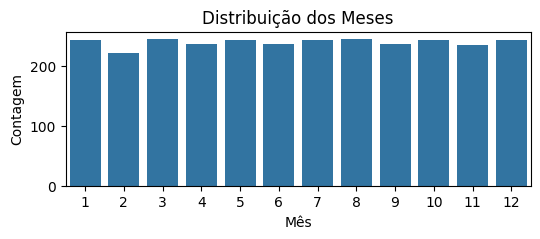

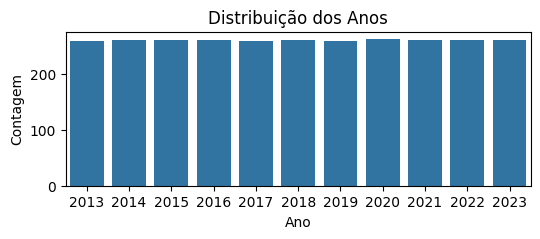

In [26]:
# Função para visualizar a distribuição dos meses e anos
def visualizar_distribuicao(df):
    plt.figure(figsize=(6, 2))
    sns.countplot(data=df, x='Mes')
    plt.title('Distribuição dos Meses')
    plt.xlabel('Mês')
    plt.ylabel('Contagem')
    plt.show()

    plt.figure(figsize=(6, 2))
    sns.countplot(data=df, x='Ano')
    plt.title('Distribuição dos Anos')
    plt.xlabel('Ano')
    plt.ylabel('Contagem')
    plt.show()

visualizar_distribuicao(df)



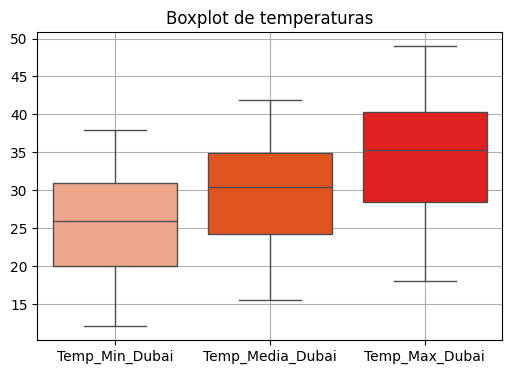

In [27]:
# Função para visualizar as temperaturas
def visualizar_temperaturas(df):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df[['Temp_Min_Dubai', 'Temp_Media_Dubai', 'Temp_Max_Dubai']], palette=['#FFA07A','#FF4500','#FF0000'])
    plt.title('Boxplot de temperaturas')
    plt.grid(True)
    plt.show()

visualizar_temperaturas(df)



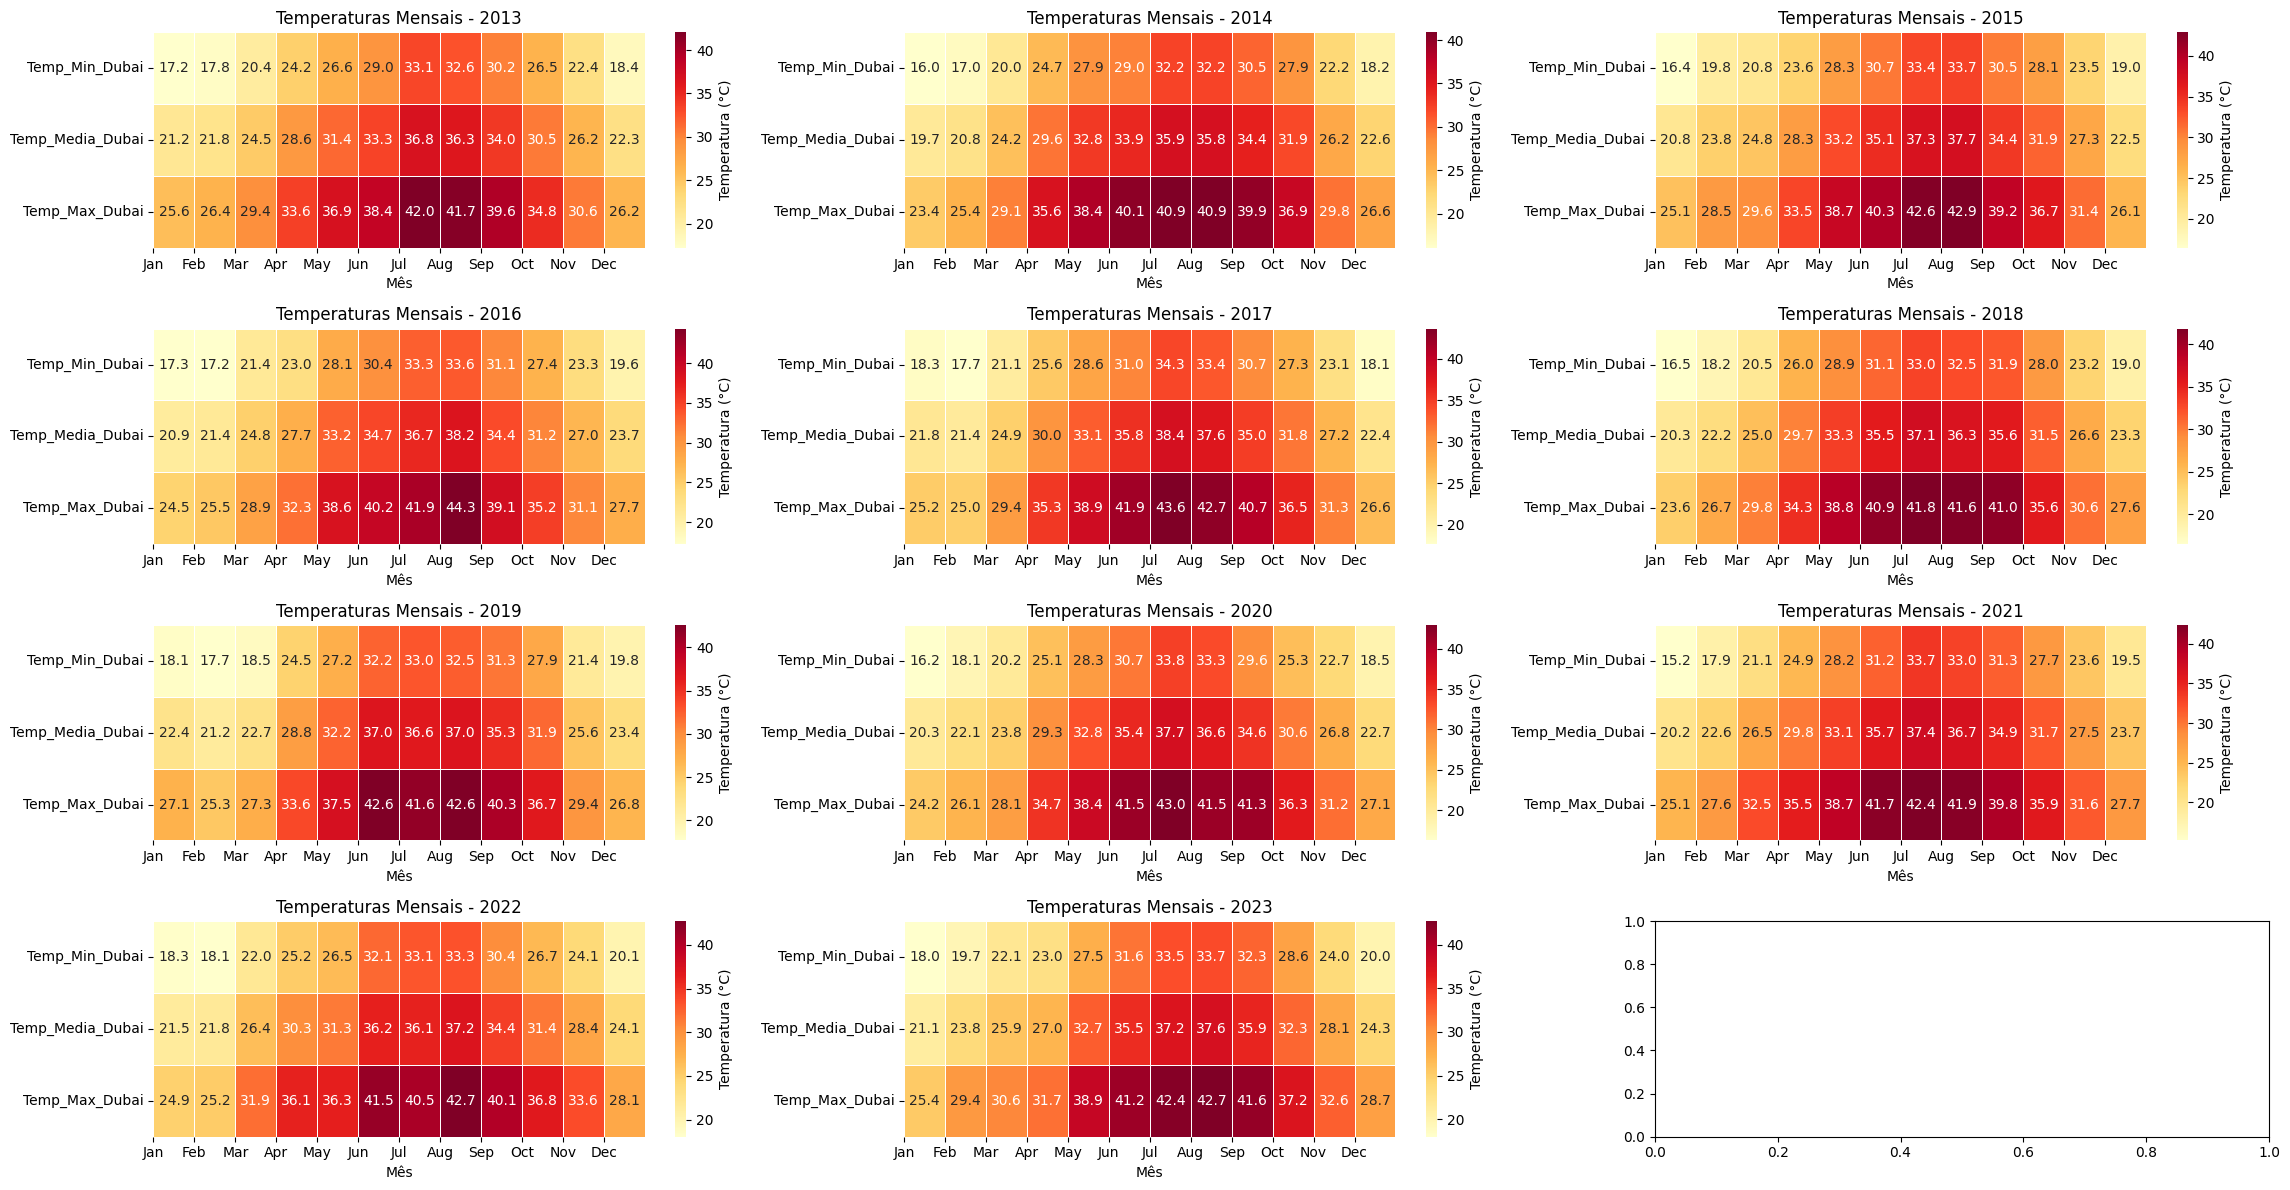

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Função para visualizar o heatmap das temperaturas mensais por ano
def visualizar_heatmap_mensal(df):
    anos = df['Ano'].unique()
    month_abbr = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }

    # Calculando o número de linhas necessário para exibir os anos em 3 colunas
    num_linhas = int(np.ceil(len(anos) / 3))

    # Configurando a figura para subplots
    fig, axs = plt.subplots(nrows=num_linhas, ncols=3, figsize=(23, 3 * num_linhas))

    for i, ano in enumerate(anos):
        row = i // 3
        col = i % 3

        df_ano = df[df['Ano'] == ano]
        heatmap_data = df_ano.groupby('Mes')[['Temp_Min_Dubai', 'Temp_Media_Dubai', 'Temp_Max_Dubai']].mean().transpose()
        month_names_abbr = [month_abbr[month] for month in range(1, 13)]

        # Plotando o heatmap no subplot correspondente ao ano
        sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Temperatura (°C)'}, ax=axs[row, col])
        axs[row, col].set_title(f'Temperaturas Mensais - {ano}')
        axs[row, col].set_xlabel('Mês')
        axs[row, col].set_ylabel('')
        axs[row, col].set_xticks(range(12))
        axs[row, col].set_xticklabels(month_names_abbr)

    # Ajuste de layout para melhor espaçamento
    plt.tight_layout()
    plt.show()

# Chamando a função para visualizar os heatmaps mensais por ano
visualizar_heatmap_mensal(df)


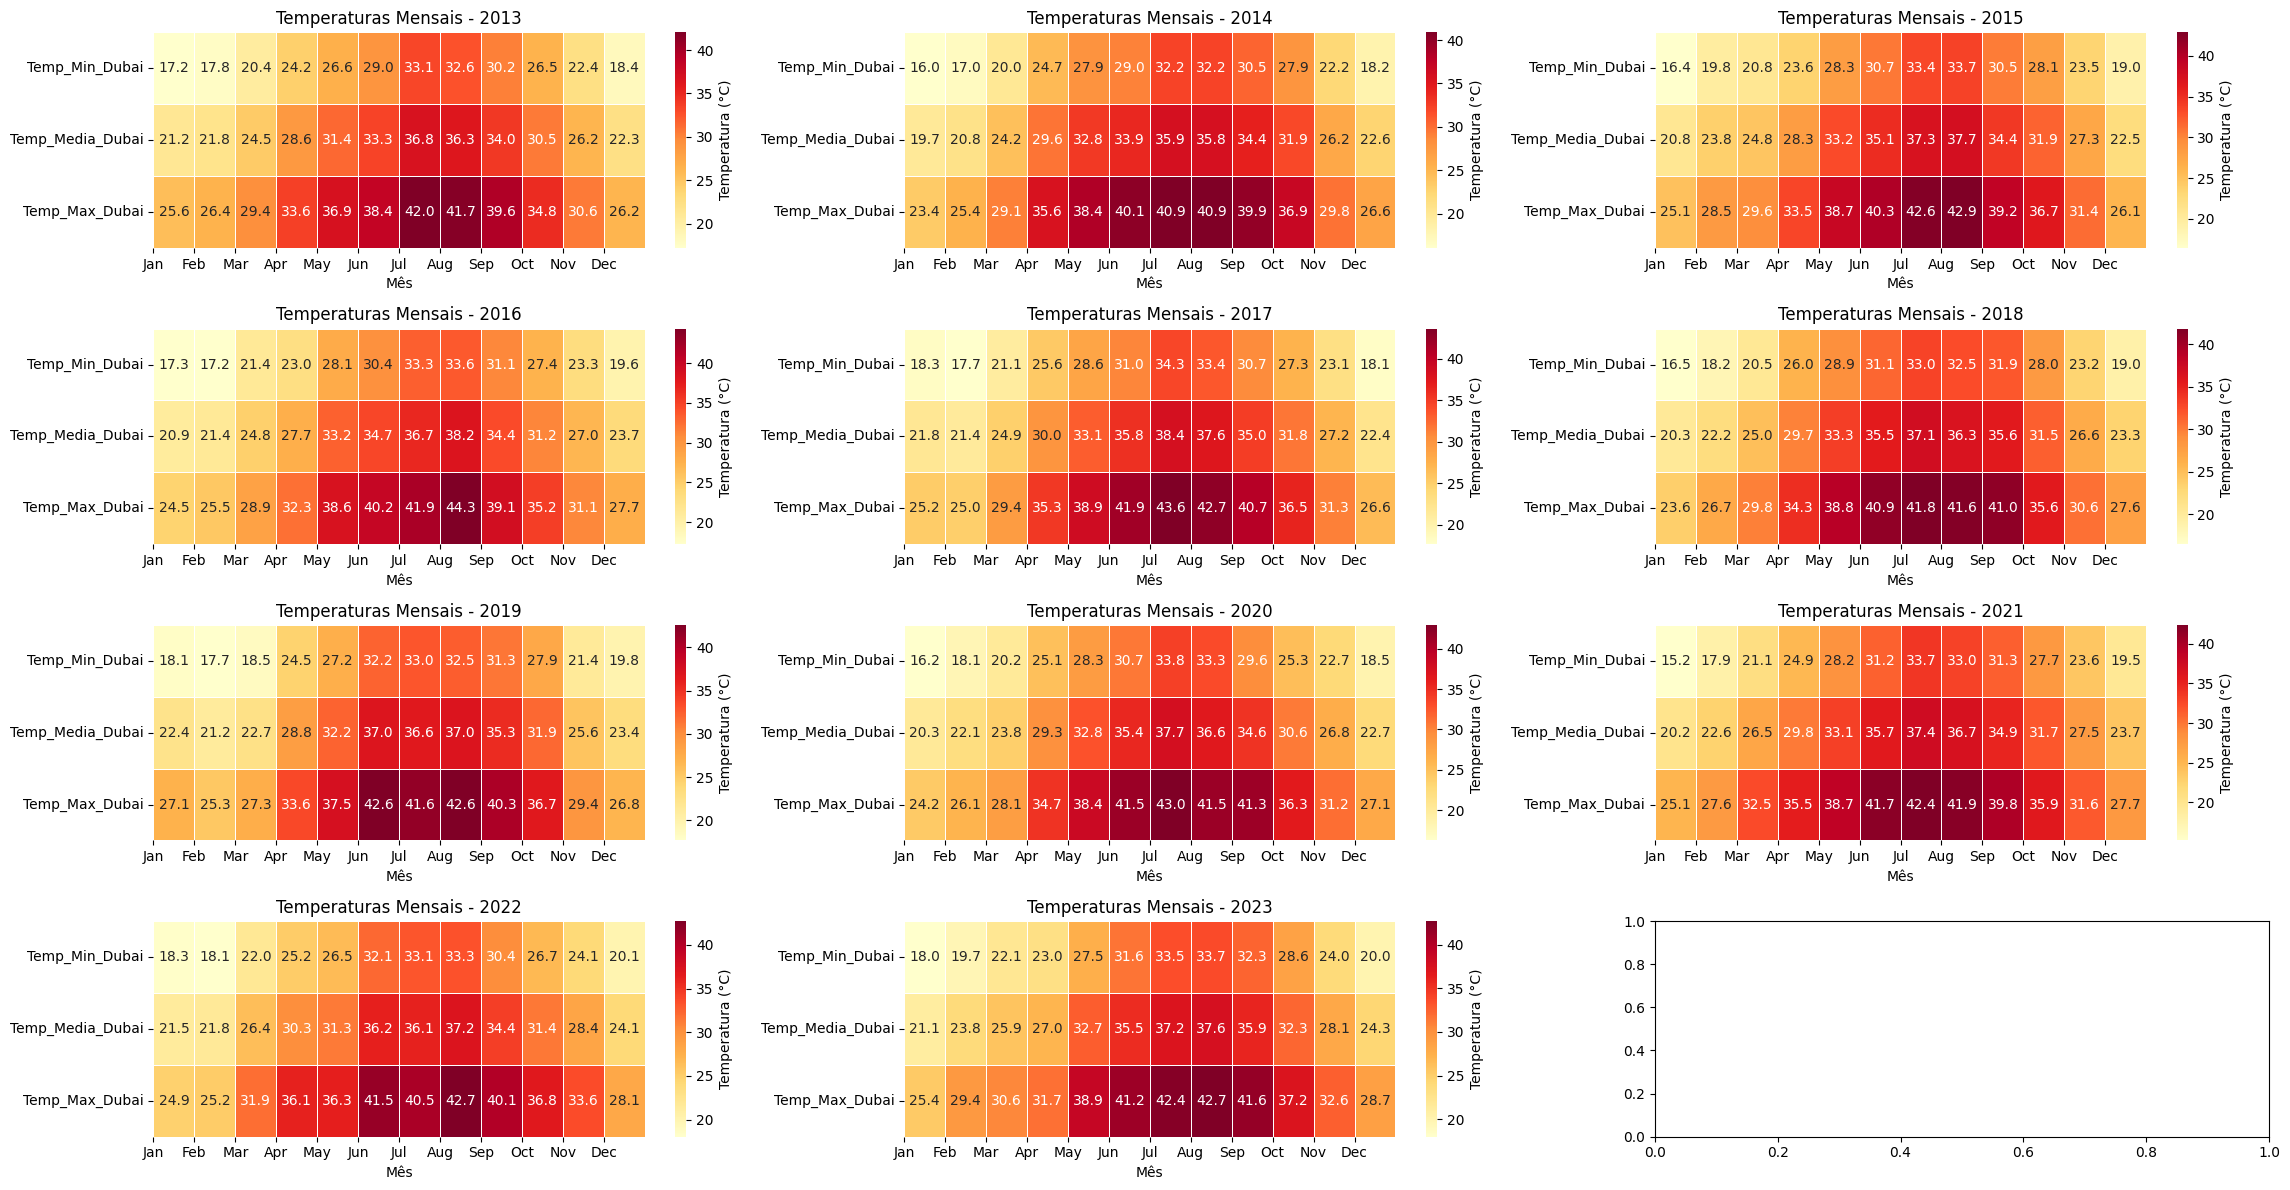

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Função para visualizar o heatmap das temperaturas mensais por ano em uma grade de 3 colunas
def visualizar_heatmap_mensal(df):
    anos = df['Ano'].unique()
    month_abbr = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }

    # Calculando o número de linhas necessário para exibir os anos em 3 colunas
    num_linhas = int(np.ceil(len(anos) / 3))

    # Configurando a figura para subplots
    fig, axs = plt.subplots(nrows=num_linhas, ncols=3, figsize=(23, 3 * num_linhas))

    for i, ano in enumerate(anos):
        row = i // 3
        col = i % 3

        df_ano = df[df['Ano'] == ano]
        heatmap_data = df_ano.groupby('Mes')[['Temp_Min_Dubai', 'Temp_Media_Dubai', 'Temp_Max_Dubai']].mean().transpose()
        month_names_abbr = [month_abbr[month] for month in range(1, 13)]

        # Plotando o heatmap no subplot correspondente ao ano
        sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Temperatura (°C)'}, ax=axs[row, col])
        axs[row, col].set_title(f'Temperaturas Mensais - {ano}')
        axs[row, col].set_xlabel('Mês')
        axs[row, col].set_ylabel('')
        axs[row, col].set_xticks(range(12))
        axs[row, col].set_xticklabels(month_names_abbr)

    # Ajuste de layout para melhor espaçamento
    plt.tight_layout()
    plt.show()

# Chamando a função para visualizar os heatmaps mensais por ano em uma grade de 3 colunas
visualizar_heatmap_mensal(df)


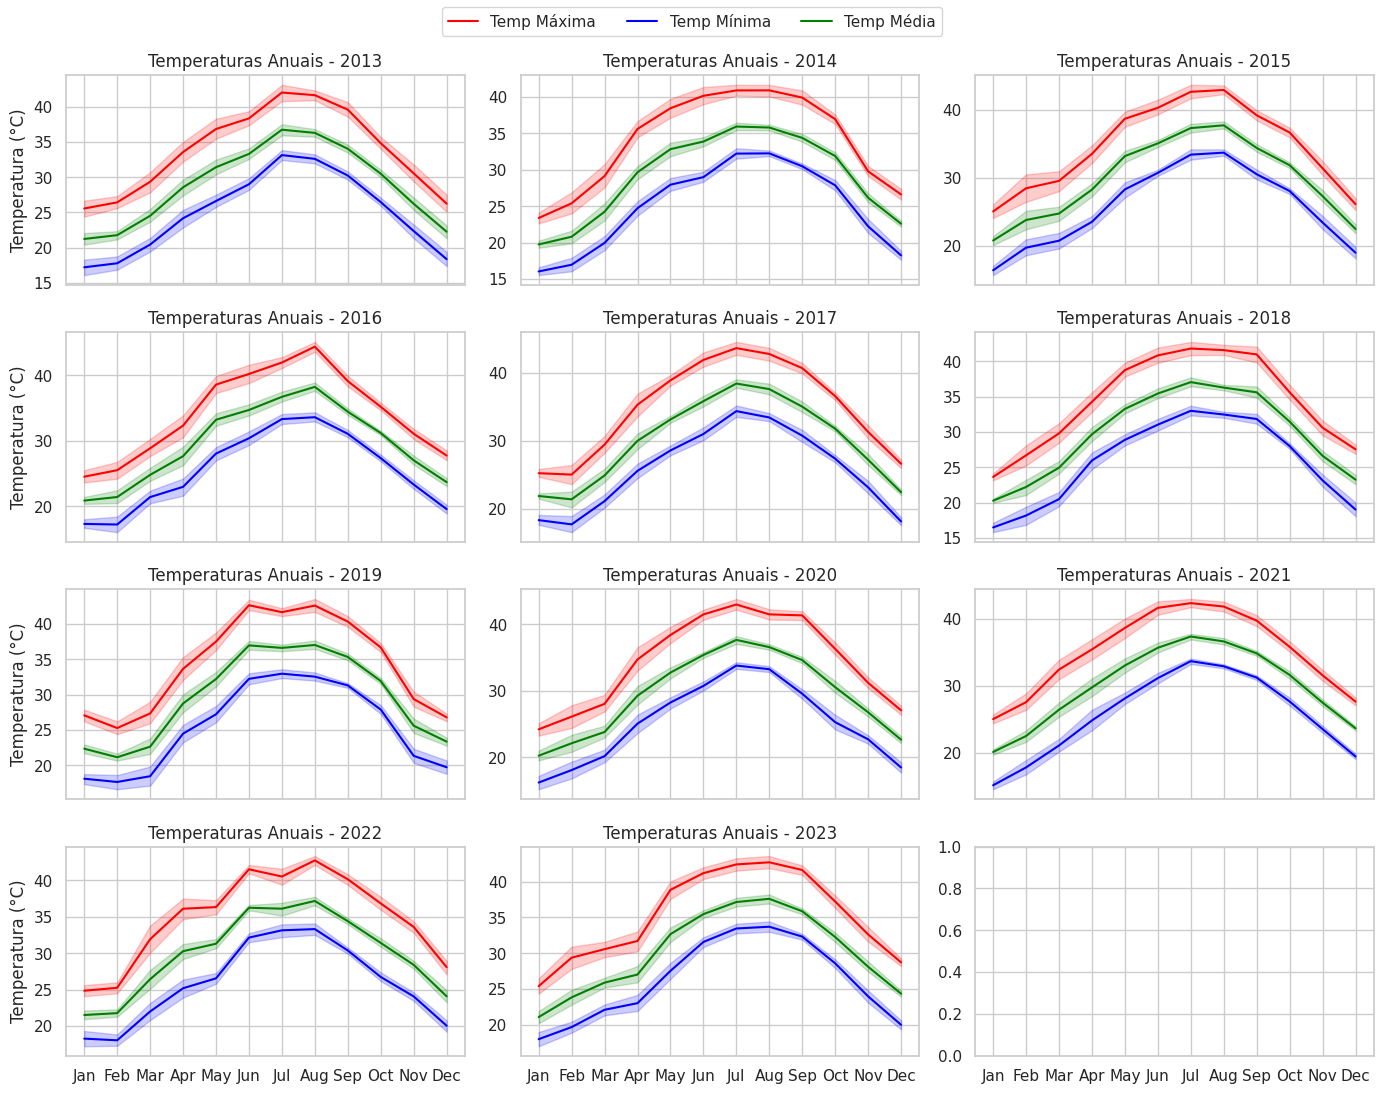

In [38]:
# Função para visualizar gráficos de linha das temperaturas por ano
def visualizar_graficos_linha(df):
    sns.set(style="whitegrid")
    meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(14, 11), sharex=True)
    axs = axs.flatten()
    for i, ano in enumerate(range(2013, 2024)):
        df_ano = df[df['Ano'] == ano]
        df_ano = df_ano.sort_values(by='Mes')
        sns.lineplot(data=df_ano, x='Mes', y='Temp_Max_Dubai', ax=axs[i], color='red', label='Temp Máxima')
        sns.lineplot(data=df_ano, x='Mes', y='Temp_Min_Dubai', ax=axs[i], color='blue', label='Temp Mínima')
        sns.lineplot(data=df_ano, x='Mes', y='Temp_Media_Dubai', ax=axs[i], color='green', label='Temp Média')
        axs[i].set_title(f'Temperaturas Anuais - {ano}')
        if i // 3 == 3:
            axs[i].set_xlabel('')
        else:
            axs[i].set_xlabel('')
        if i % 3 == 0:
            axs[i].set_ylabel('Temperatura (°C)')
        else:
            axs[i].set_ylabel('')
        axs[i].legend().remove()
        axs[i].set_xticks(range(1, 13))
        axs[i].set_xticklabels(meses)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


visualizar_graficos_linha(df)


# Criar esquema estrela no Postgree

In [41]:
# Iniciar o PostgreSQL
!service postgresql start


 * Starting PostgreSQL 14 database server
   ...done.


In [47]:
# Função para conectar ao PostgreSQL
def conectar_postgresql():
    try:
        dbname = os.getenv('POSTGRES_DB')
        user = os.getenv('POSTGRES_USER')
        password = os.getenv('POSTGRES_PASSWORD')
        host = os.getenv('POSTGRES_HOST')
        port = os.getenv('POSTGRES_PORT')

        conn = psycopg2.connect(
            dbname=dbname,
            user=user,
            password=password,
            host=host,
            port=port
        )
        return conn
    except Exception as e:
        print(f'Erro ao conectar ao PostgreSQL: {str(e)}')
        return None

# Conectar ao PostgreSQL
conn = conectar_postgresql()
if conn is not None:
    print("Conexão bem-sucedida ao PostgreSQL!")
else:
    print("Não foi possível conectar ao PostgreSQL.")


Conexão bem-sucedida ao PostgreSQL!


In [50]:
import os
import psycopg2

# Função para criação das tabelas de um esquema estrela no PostgreSQL
def criar_tabelas(conn):
    try:
        if conn is not None:
            cur = conn.cursor()

            tabelas = {
                "dim_data": """
                    CREATE TABLE IF NOT EXISTS dim_data (
                        id SERIAL PRIMARY KEY,
                        data DATE,
                        dia INT,
                        mes INT,
                        ano INT
                    );
                """,
                "dim_temperatura": """
                    CREATE TABLE IF NOT EXISTS dim_temperatura (
                        id SERIAL PRIMARY KEY,
                        temp_max_dubai FLOAT,
                        temp_min_dubai FLOAT,
                        temp_media_dubai FLOAT
                    );
                """,
                "dim_moeda": """
                    CREATE TABLE IF NOT EXISTS dim_moeda (
                        id SERIAL PRIMARY KEY,
                        usd_aed_open FLOAT,
                        usd_aed_high FLOAT,
                        usd_aed_low FLOAT,
                        usd_aed_close FLOAT,
                        usd_brl_open FLOAT,
                        usd_brl_high FLOAT,
                        usd_brl_low FLOAT,
                        usd_brl_close FLOAT,
                        aed_brl_open FLOAT,
                        aed_brl_high FLOAT,
                        aed_brl_low FLOAT,
                        aed_brl_close FLOAT
                    );
                """,
                "fato_temperatura_moeda": """
                    CREATE TABLE IF NOT EXISTS fato_temperatura_moeda (
                        id SERIAL PRIMARY KEY,
                        data_id INT,
                        temperatura_id INT,
                        moeda_id INT,
                        FOREIGN KEY (data_id) REFERENCES dim_data(id),
                        FOREIGN KEY (temperatura_id) REFERENCES dim_temperatura(id),
                        FOREIGN KEY (moeda_id) REFERENCES dim_moeda(id)
                    );
                """
            }

            for tabela, query in tabelas.items():
                cur.execute(query)
                cur.execute(f"SELECT to_regclass('{tabela}')")
                existe = cur.fetchone()[0]
                if existe:
                    print(f"Tabela {tabela} já existe.")
                else:
                    print(f"Tabela {tabela} foi criada.")

            # Confirmar transações
            conn.commit()

            # Fechar o cursor
            cur.close()
        else:
            print("Não foi possível conectar ao PostgreSQL.")
    except Exception as e:
        print(f'Erro ao criar tabelas: {str(e)}')

conn = conectar_postgresql()
if conn is not None:
    criar_tabelas(conn)
    conn.close()


Tabela dim_data já existe.
Tabela dim_temperatura já existe.
Tabela dim_moeda já existe.
Tabela fato_temperatura_moeda já existe.


In [ ]:
# Função para inserir os dados no esquema estrela do Postgre
def inserir_dados_esquema_estrela(conn, df):
    try:
        if conn is not None:
            cur = conn.cursor()

            for index, row in df.iterrows():
                # Inserir dados na tabela dim_data
                cur.execute("""
                INSERT INTO dim_data (data, dia, mes, ano)
                VALUES (%s, %s, %s, %s)
                RETURNING id;
                """, (row['Date'], row['Date'].day, row['Date'].month, row['Date'].year))
                data_id = cur.fetchone()[0]

                # Inserir dados na tabela dim_temperatura
                cur.execute("""
                INSERT INTO dim_temperatura (temp_max_dubai, temp_min_dubai, temp_media_dubai)
                VALUES (%s, %s, %s)
                RETURNING id;
                """, (row['Temp_Max_Dubai'], row['Temp_Min_Dubai'], row['Temp_Media_Dubai']))
                temperatura_id = cur.fetchone()[0]

                # Inserir dados na tabela dim_moeda
                cur.execute("""
                INSERT INTO dim_moeda (
                    usd_aed_open, usd_aed_high, usd_aed_low, usd_aed_close,
                    usd_brl_open, usd_brl_high, usd_brl_low, usd_brl_close,
                    aed_brl_open, aed_brl_high, aed_brl_low, aed_brl_close
                )
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                RETURNING id;
                """, (
                    row['USD_AED_Open'], row['USD_AED_High'], row['USD_AED_Low'], row['USD_AED_Close'],
                    row['USD_BRL_Open'], row['USD_BRL_High'], row['USD_BRL_Low'], row['USD_BRL_Close'],
                    None, None, None, None  # Supondo que não há dados para AED/BRL
                ))
                moeda_id = cur.fetchone()[0]

                # Inserir dados na tabela fato_temperatura_moeda
                cur.execute("""
                INSERT INTO fato_temperatura_moeda (data_id, temperatura_id, moeda_id)
                VALUES (%s, %s, %s);
                """, (data_id, temperatura_id, moeda_id))

            # Confirmar transações
            conn.commit()

            # Fechar o cursor
            cur.close()
        else:
            print("Não foi possível conectar ao PostgreSQL.")
    except Exception as e:
        print(f'Erro ao inserir dados no esquema estrela: {str(e)}')

# Chamando a função
conn = conectar_postgresql()
if conn is not None:
    inserir_dados_esquema_estrela(conn, df)
    conn.close()

Inserção dos Dados no Banco de dados

In [ ]:
# Conectar ao banco de dados
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
cur = conn.cursor()

# Inserir dados nas tabelas
for index, row in df.iterrows():
    # Inserir dados na tabela de dimensão de data
    cur.execute("INSERT INTO dim_data (data, dia, mes, ano) VALUES (%s, %s, %s, %s) RETURNING id;",
                (row['Date'], row['Dia'], row['Mes'], row['Ano']))
    data_id = cur.fetchone()[0]

    # Inserir dados na tabela de dimensão de temperatura
    cur.execute("INSERT INTO dim_temperatura (temp_max_dubai, temp_min_dubai, temp_media_dubai) VALUES (%s, %s, %s) RETURNING id;",
                (row['Temp_Max_Dubai'], row['Temp_Min_Dubai'], row['Temp_Media_Dubai']))
    temperatura_id = cur.fetchone()[0]

    # Inserir dados na tabela de dimensão de moeda
    cur.execute("""
        INSERT INTO dim_moeda (usd_aed_open, usd_aed_high, usd_aed_low, usd_aed_close,
                               usd_brl_open, usd_brl_high, usd_brl_low, usd_brl_close,
                               aed_brl_open, aed_brl_high, aed_brl_low, aed_brl_close)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s) RETURNING id;
        """,
        (row['USD_AED_Open'], row['USD_AED_High'], row['USD_AED_Low'], row['USD_AED_Close'],
         row['USD_BRL_Open'], row['USD_BRL_High'], row['USD_BRL_Low'], row['USD_BRL_Close'],
         row['AED_BRL_Open'], row['AED_BRL_High'], row['AED_BRL_Low'], row['AED_BRL_Close']))
    moeda_id = cur.fetchone()[0]

    # Inserir dados na tabela de fatos
    cur.execute("INSERT INTO fato_temperatura_moeda (data_id, temperatura_id, moeda_id) VALUES (%s, %s, %s);",
                (data_id, temperatura_id, moeda_id))

# Confirmar transações
conn.commit()

# Fechar cursor e conexão
cur.close()
conn.close()

print("Dados inseridos com sucesso.")


Dados inseridos com sucesso.


OLAP e Dashboards


Análise de Dados e Modelos Preditivos
